Data sets format: 
files:
* TotalFlights.csv
* DelayFlights.csv
* DelayRatio.csv
* airport2idx.csv
* time_stamp2idx.csv
* test.csv
* readme.ipynb

this.ipynb provide helper function to generate the following data:

* `TotalFlights`: pd.DataFrame with value  of shape (A,N)

`TotalFlights[i,t]` is number of flights between [`idx2time_stamp[t]`,`idx2time_stamp[t] + dt`) at airport `idx2airport[i]`

* `DelayFlights`: pd.DataFrame with value of shape (A,N)

`DelayFlights[i,t]` is number of delayed flights between [`idx2time_stamp[t]`,`idx2time_stamp[t] + dt`) at airport `idx2airport[i]`

* `DelayRatio`:  pd.DataFrame with value of shape (A,N)

`DelayRatio[i,t] = DelayFlights[i,t] / TotalFlights[i,t]`


* `idx2airport`: dict 

`idx2airport[i]` return  the iata name for airport index ` i `

* `airport2idx`: dict

inverse to `idx2airport`

* `idx2time_stamp`: dict

`idx2time_stamp[t]` return  the timestamp for time index ` t `

* `time_stamp2idx`: dict

inverse to `idx2time_stamp[t]`

* `dt`:pd.TimeDelta 

`1D` or `1H` so far

* `test_index` :list of lenth M
element is time index at which model predicts the delay ratio. In our case, all elements `tidx in test_index`' satisfy `idx2time_stamp[tidx]` after `2018-01-01 00:00:00`

`readme.ipynb` also provide a model evaluation function `model_mse(pred_data)`. 

* 1. run next block to generate data
* 2. tune your model, generate a np.ndarrays obeject `pred_data` of shape  `(A,M)`
`pred_data[:,j]` gives the predicted delay ratio for time index `test_index[j]`
* 3. report `model_mse(pred_data)`, save `pred_data`

In **this** notebook, `dt` is 1 day. datasets contain `pd.date_range('2007-01-01 00:00:00','2008-12-30 00:00:00',freq='d')` as time stamp. 
When using model to pridiction. one **CAN NOT** use the data at or after `idx2time_stamp[t]` to

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta

def fun25_import_datasets():
    idx2airport=pd.read_csv("idx2airport.csv",index_col=0)['0'].to_dict()
    airport2idx=pd.read_csv("airport2idx.csv",index_col=0)['0'].to_dict()
    idx2time_stamp=pd.read_csv("idx2time_stamp.csv",index_col=0)['0'].to_dict()
    time_stamp2idx=pd.read_csv("time_stamp2idx.csv",index_col=0)['0'].to_dict()
    TotalFlights=pd.read_csv("TotalFlights.csv",index_col=0)
    DelayFlights=pd.read_csv("DelayFlights.csv",index_col=0)
    DelayRatio=pd.read_csv("DelayRatio.csv",index_col=0)
    test_index=list(pd.read_csv("test.csv",index_col=0,header=None).values.T[0,:])
    dt=timedelta(seconds=3600) #1H
    
    return idx2airport,airport2idx,idx2time_stamp,time_stamp2idx,TotalFlights,DelayFlights,DelayRatio,test_index,dt

def model_mse(pred_data,test_data=None):
    test_index=list(pd.read_csv("test.csv",index_col=0,header=None).values.T[0,:])
    DelayRatio=pd.read_csv("DelayRatio.csv",index_col=0)
    return np.mean(np.mean(np.square(DelayRatio[:,test_index]-pred_data),axis=0))

In [2]:
#Demo 1
idx2airport,airport2idx,idx2time_stamp,time_stamp2idx,TotalFlights,DelayFlights,DelayRatio,test_index,dt=fun25_import_datasets()

# 1.1 数据的理解和使用

In [15]:
type(DelayRatio)

pandas.core.frame.DataFrame

In [16]:
DelayRatio.shape

(311, 730)

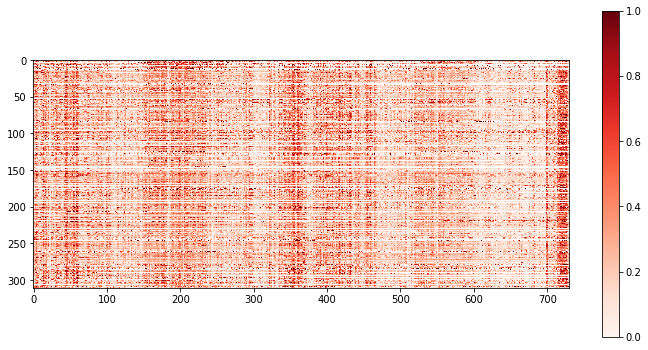

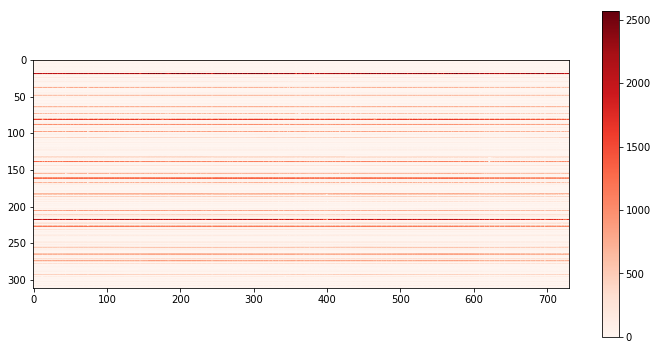

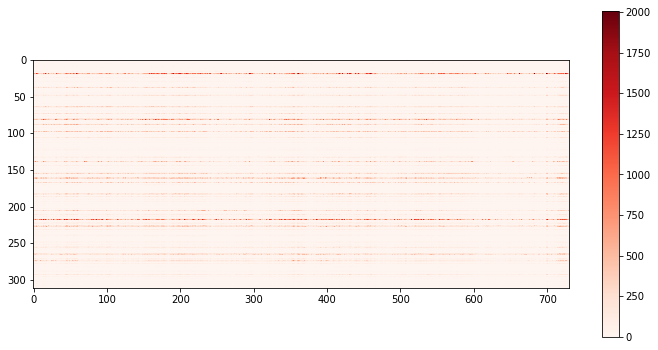

In [177]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,6)

plt.imshow(DelayRatio)
plt.set_cmap('Reds')
plt.colorbar()
plt.show()

plt.imshow(TotalFlights)
plt.set_cmap('Reds')
plt.colorbar()
plt.show()


plt.imshow(DelayFlights)
plt.set_cmap('Reds')
plt.colorbar()
plt.show()

# 1.2 变成numpy ndarray数据类型

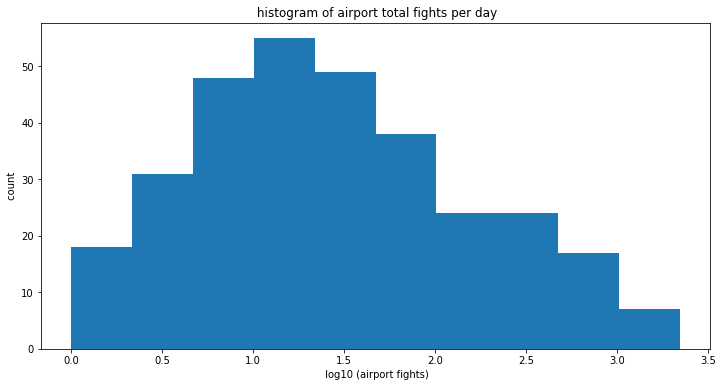

Numbers of airport with daily total flights larger than 30 is 134
[2, 13, 15, 16, 19, 20, 21, 25, 30, 36, 37, 38, 45, 46, 47, 48, 49, 51, 52, 58, 60, 62, 64, 65, 69, 71, 74, 77, 78, 80, 81, 82, 87, 88, 93, 95, 96, 98, 102, 106, 108, 109, 111, 113, 119, 120, 122, 123, 124, 132, 133, 134, 136, 138, 139, 140, 144, 148, 150, 153, 154, 155, 157, 160, 162, 163, 165, 167, 168, 169, 170, 178, 180, 182, 183, 184, 186, 188, 190, 191, 193, 196, 198, 202, 203, 205, 206, 209, 211, 212, 213, 214, 216, 217, 218, 222, 223, 225, 226, 227, 231, 234, 238, 239, 240, 244, 247, 249, 251, 254, 255, 256, 257, 258, 260, 263, 264, 265, 266, 268, 270, 272, 273, 275, 277, 281, 282, 288, 292, 295, 297, 302, 304, 307]


In [275]:
p = DelayRatio.values
A = DelayFlights.values
B = TotalFlights.values

daily = np.sum(B,axis = 1) / B.shape[1]

plt.hist( np.log10( daily  + 1 ) )
plt.title(" histogram of airport total fights per day")
plt.xlabel(" log10 (airport fights)")
plt.ylabel(" count ")
plt.show()

DailyThreshold = 30

d = []
for i,val in enumerate(daily):
    if val > DailyThreshold:
        d.append( i )
        
print( "Numbers of airport with daily total flights larger than" , DailyThreshold , "is" , len(d) )
print(d)

# 1.3 小机场的舍去，大机场序号。

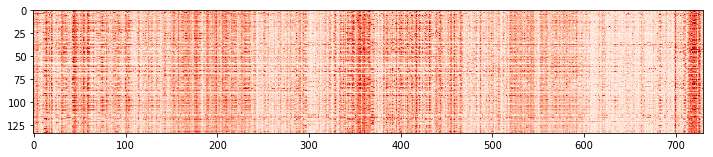

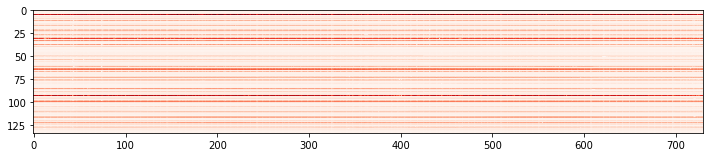

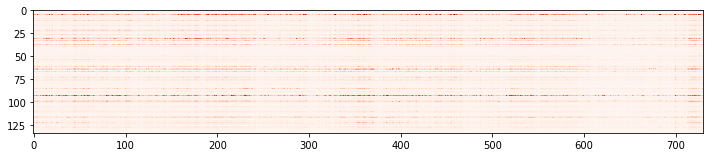

In [298]:
AX = np.ndarray( (len(d), len(B[0]) ) )
BX = np.ndarray( (len(d), len(B[0]) ) )
pX = np.ndarray( (len(d), len(B[0]) ) )

k = 0
for i in d:
    AX[k] = A[i]
    BX[k] = B[i]
    for j in range( len(B[0]) ):  
        if B[i][j] == 0:
            pX[k][j] = 0
        else:
            pX[k][j] = A[i][j]/B[i][j]
    k = k + 1

plt.imshow(pX)
plt.set_cmap('Reds')
#plt.colorbar()
plt.show()

plt.imshow(BX)
plt.set_cmap('Reds')
#plt.colorbar()
plt.show()


plt.imshow(AX)
plt.set_cmap('Reds')
#plt.colorbar()
plt.show()

# 关于$d_i$和$b_{ij}$的线性回归模型 及其变种
离散化ODE后得到:
$$
p[i,t+1] = p[i,t] + dt * \Big[ -d_i * p[i,t] +  \big( b_{i1} p[1,t] + b_{i2} p[2,t] + ... \big) (1-p[i,t]) \Big]
$$
假设 $dt = 1$, 把此问题写成线性回归的标准形式：
$$
 - p[i,t]  * d_i +  (1-p[i,t])p[1,t]  b_{i1}  + (1-p[i,t])p[2,t] b_{i2}  + ... =  p[i,t+1] - p[i,t]
$$
假设给定机场数目$n=311$,时间一共有$m=365$（取一年为训练集），  
那么待求系数一共有$(n^2 + n)=10万$个，差分方程的个数是$n*(m-1)=12万$

1. 10万乘以10万这样规模的矩阵运算很耗费时间。
2. 系数$b_{ij}$是机场之间的关联，根据常识，它是很稀疏的，考虑使用Lasso方案。
3. 取吞吐量大的30个机场研究。这时候会有“泄露”问题，增加额外的参数去表示。
4. 方程的其他形式，例如 $dp_i/dt = - d_i p_i + \sum_j d_{ij}p_j $ 
5. 基于马尔科夫过程的回归 $ p_{i,t} = \sum A_{ij} p_{j,t-1}  + \sum \sum B_{ijk} p_{j,t-1} p_{k,t-1} $
6. 单因子平均场模型，$dp_i/dt = - d_i p_i + a_i p_0 + b_i p_0 (1-p_i) $ 这个$p_0$的含义就是所有机场的平均。

# (1)建模(2)拟合(3)测试
我们的数据是给定的，有拟合数据，测试数据。  
建模拟合都是在线性回归框架之下，拟合参数要向量化处理。  
测试时，我们求测试数据的“均方根”。  
这一切都可以程序化进行。

In [362]:
def model_db_run( p0 , p1 ):

    # p0[i,t] is fitting data
    # p1[i,t] is testing data
    n0 = len( p0 )
    time0 = len( p0[0] )
    
    n1 = len( p1 )
    time1 = len( p1[0] )
    if n1 != n0:
        print("ERROR, fitting data and testing data not consistent")
        return None
    
    # (1) Modeling
    # this model contains 3*n0 parameters
    # the fitting contains (time0-1)*n0 identities
    # those parameters are decoupled into n0 groups
    # therefore, we have each (time0-1) identiites to fit 3 parameters.
    
    X = np.ndarray( ( (time0-1)*n0 , n0+n0**2 ))
    y = np.ndarray( ( (time0-1)*n0 , )         )
    print(X)
    print(y)
    
    reg = linear_model.LinearRegression()
    reg.fit(X, y )
    print( type( reg.coef_ ) )
    

    k = np.ndarray( shape=(n1,time1) )
    for i in range(n1):
        for t in range( time1 ):
            k[i,t] = sum( p1[j,t] * (1-p1[i,t]) * b[i,j] for j in range(n1) )
    out = 0
    for i in range(n1):
        for t in range( 1 , time1 ):
            p1hat = p1[i,t-1] - d_s[i] * p1[i,t-1] + k[i,t-1]
            out = out + (p1[i,t] - p1hat)**2
    out = np.sqrt( out/(n1*(time1-1)) )
    return out

In [363]:
model_db_run( pX[:,:365], pX[:,365:] )

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[6.90871324e-310 4.65032742e-310 4.65032821e-310 ... 4.65032748e-310
 2.37151510e-322 2.37151510e-322]


/home/jian/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/jian/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [341]:
def model_singleIndex3_run( p0 , p1 ):

    # p0[i,t] is fitting data
    # p1[i,t] is testing data
    n0 = len( p0 )
    time0 = len( p0[0] )
    
    n1 = len( p1 )
    time1 = len( p1[0] )
    if n1 != n0:
        print("ERROR, fitting data and testing data not consistent")
        return None
    
    # (1) Modeling
    # this model contains 3*n0 parameters
    # the fitting contains (time0-1)*n0 identities
    # those parameters are decoupled into n0 groups
    # therefore, we have each (time0-1) identiites to fit 3 parameters.
    
    p_ave = np.mean(p0 , axis = 0)
    
    def get_d_a_b( i ):
        X = np.ndarray( ( time0-1 , 3 ) )
        y = np.ndarray( ( time0-1 , )   )
        
        # $dp_i/dt = - d_i p_i + a_i p_0 + b_i p_0 (1-p_i) $
        
        for t in range( time0 - 1 ):
            y[t] = p0[i][t+1] - p0[i][t]
            
            X[t][0] = - p0[i][t]
            X[t][1] = p_ave[t]
            X[t][2] = p_ave[t] * (1-p0[i][t])
        
        reg = linear_model.LinearRegression()
        reg.fit(X, y )
        d,a,b = reg.coef_
        
        return d,a,b
    
    
    d_s = []
    a_s = []
    b_s = []
    
    for i in range(n0):
        d,a,b = get_d_a_b(i) 
        d_s.append( d )
        a_s.append( a )
        b_s.append( b )
        
    
    # (2) testing
    
    p1_ave = np.mean(p1 , axis = 0)
    
    out = 0
    
    for i in range(n1):
        for t in range( 1 , time1 ):
            p1hat = p1[i,t-1] - d_s[i] * p1[i,t-1] + a_s[i] * p1_ave[t-1] \
            + b_s[i] * p1_ave[t-1] * ( 1 -  p1[i,t-1] )
            out = out + (p1[i,t] - p1hat)**2
    out = np.sqrt( out/(n1*(time1-1)) )
    return out

In [342]:
model_singleIndex3_run( pX[:,:365], pX[:,365:] )
#model_singleIndex2_run( pX , pX  )


0.15161328650150993

In [343]:

def model_singleIndex2_run( p0 , p1 ):

    # p0[i,t] is fitting data
    # p1[i,t] is testing data
    n0 = len( p0 )
    time0 = len( p0[0] )
    
    n1 = len( p1 )
    time1 = len( p1[0] )
    if n1 != n0:
        print("ERROR, fitting data and testing data not consistent")
        return None
    
    # (1) Modeling
    # this model contains 3*n0 parameters
    # the fitting contains (time0-1)*n0 identities
    # those parameters are decoupled into n0 groups
    # therefore, we have each (time0-1) identiites to fit 3 parameters.
    
    p_ave = np.mean(p0 , axis = 0)
    
    def get_d_a_b( i ):
        
        X = np.ndarray( ( time0-1 , 2 ) )
        y = np.ndarray( ( time0-1 , )   )
        
        # $dp_i/dt = - d_i p_i + a_i p_0 + b_i p_0 (1-p_i) $
        
        for t in range( time0 - 1 ):
            y[t] = p0[i][t+1] - p0[i][t]
            
            X[t][0] = - p0[i][t]
            #X[t][1] = p_ave[t]
            X[t][1] = p_ave[t] * (1-p0[i][t])
        
        reg = linear_model.LinearRegression()
        reg.fit(X, y )
        d,b = reg.coef_
        
        return d,b
    
    
    d_s = []
    b_s = []
    
    for i in range(n0):
        d,b = get_d_a_b(i) 
        d_s.append( d )
        b_s.append( b )

    # (2) testing
    
    p1_ave = np.mean(p1 , axis = 0)
    
    out = 0
    
    for i in range(n1):
        for t in range( 1 , time1 ):
            p1hat = p1[i,t-1] - d_s[i] * p1[i,t-1] \
            + b_s[i] * p1_ave[t-1] * ( 1 -  p1[i,t-1] )
            out = out + (p1[i,t] - p1hat)**2
    out = np.sqrt( out/(n1*(time1-1)) )
    return out

In [344]:
model_singleIndex2_run( pX[:,:365], pX[:,365:] )

0.13503272635034547

In [345]:
def model_naive_run( p0 , p1 ):

    # p0[i,t] is fitting data
    # p1[i,t] is testing data
    n0 = len( p0 )
    time0 = len( p0[0] )
    
    n1 = len( p1 )
    time1 = len( p1[0] )
    if n1 != n0:
        print("ERROR, fitting data and testing data not consistent")
        return None
    
    out = 0
    
    for i in range(n1):
        for t in range( 1 , time1 ):
            p1hat = p1[i,t-1]
            out = out + (p1[i,t] - p1hat)**2
    out = np.sqrt( out/(n1*(time1-1)) )
    return out

In [346]:
model_naive_run( pX[:,:365], pX[:,365:] )

0.13512134756285346

In [358]:
def model_naive2_run( p0 , p1 ):

    # p0[i,t] is fitting data
    # p1[i,t] is testing data
    n0 = len( p0 )
    time0 = len( p0[0] )
    
    n1 = len( p1 )
    time1 = len( p1[0] )
    if n1 != n0:
        print("ERROR, fitting data and testing data not consistent")
        return None
    
    out = 0
    
    for i in range(n1):
        for t in range( 2 , time1 ):
            p1hat = 0.7*p1[i,t-1] + 0.3*p1[i,t-2]
            out = out + (p1[i,t] - p1hat)**2
    out = np.sqrt( out/(n1*(time1-2)) )
    return out

In [359]:
model_naive2_run( pX[:,:365], pX[:,365:] )

0.1291519302818644

# Linear regression 程序包使用
## 原味，Ridge，Lasso
首先我将构造数据， 然后用模型反解回来，作对比。

In [125]:
plt.rcParams["figure.figsize"] = (12,2)

In [149]:
import numpy as np

p = 100
n = 300

w = np.random.randn( p )
w0 = 10
X = np.random.randn( n , p  )
y = np.matmul( X ,   w ) + w0
y = y + np.random.randn( len(y) )/5

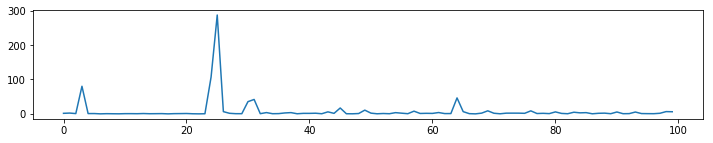

In [150]:
from sklearn import linear_model
reg = linear_model.LinearRegression()
reg.fit(X, y )
#print(reg.intercept_ )
plt.plot( abs( (reg.coef_ - w )/ w )*100 ) 
plt.show()

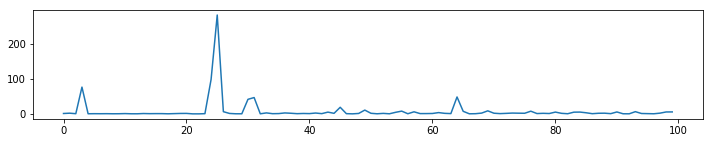

In [151]:
reg = linear_model.Ridge(alpha=.5)
reg.fit(X, y )
plt.plot( abs( (reg.coef_ - w )/ w )*100 ) 
plt.show()

1e-06


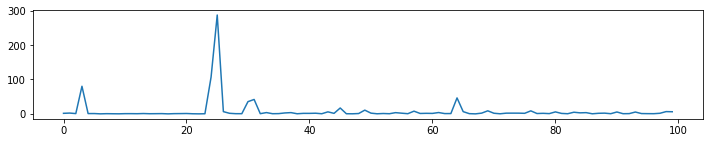

In [152]:
reg = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
reg.fit(X, y )
print(reg.alpha_ )
plt.plot( abs( (reg.coef_ - w )/ w )*100 ) 
plt.show()

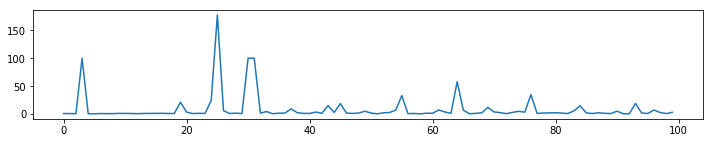

In [159]:
reg = linear_model.Lasso(alpha=0.005)
reg.fit(X, y )
plt.plot( abs( (reg.coef_ - w )/ w )*100 ) 
plt.show()

# 只取部分机场
假设原来的模型仍然成立，我需要